<h1>Sentiment Analysis using Twitter Data</h1

<h2>Introduction </h2>
Social media platforms, especially Twitter, have become a powerful medium for people to express their opinions, emotions, and reactions to world events. The vast amount of unstructured textual data generated daily offers an opportunity to analyze public sentiment using Natural Language Processing (NLP) techniques. Sentiment analysis helps in understanding whether a tweet conveys a positive or negative opinion, making it valuable for businesses, governments, researchers, and media organizations.

<br>
<h2>Problem Statement</h2>
Twitter contains millions of tweets that express opinions on products, politics, entertainment, and social issues. However, this data is:

- Unstructured: Tweets contain slang, hashtags, emojis, and contractions.
- High-volume: The scale of data requires efficient preprocessing and modeling.
- Noisy: Tweets may include irrelevant information, misspellings, and short forms.

The problem is to build a robust sentiment analysis model that can automatically classify tweets into sentiment categories (e.g., positive, negative) by:

- Preprocessing and cleaning the raw text (tokenization, stopword removal, lemmatization, etc.).

- Representing text as numerical vectors using word embeddings (Word2Vec, FastText).

- Training traditional ML models (Logistic Regression, SVM, Naive Bayes) on these embeddings.

- Evaluating model performance using accuracy and F1-score to determine the best approach.

The outcome is a trained sentiment classification model that can later be deployed into a web application, where users can input text and instantly receive sentiment predictions.


<h2> Setup and Installation </h2>

In [1]:
!pip -q install numpy joblib contractions gensim scikit-learn matplotlib -U
%rehashx
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 r

In [1]:
# Standard Library
import os
import re
import random
import warnings
warnings.filterwarnings('ignore')

# Core Data & Utilities
import numpy as np
import pandas as pd
pd.set_option("display.float_format", "{:.2f}".format)
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text Processing & NLP
import contractions
import nltk
import tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Machine Learning (Scikit-learn)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB

# Word Embeddings (Gensim)
from gensim.models import Word2Vec, FastText
from gensim.models.keyedvectors import KeyedVectors

# Scientific Computation
from scipy.sparse import csr_matrix

# Hugging Face Datasets & Transformers
from datasets import Dataset, load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# Deep Learning
import torch

# Gradio (Interactive UI)
import gradio as gr

### Dataset Retrieval (Kaggle)
We will retrieve the dataset directly from Kaggle using the Kaggle API.  

In [2]:
# Upload Kaggle API Key
from google.colab import files
print("Upload your kaggle.json (Kaggle -> Profile -> Settings -> Create New API Token)")
files.upload();  # select kaggle.json

Upload your kaggle.json (Kaggle -> Profile -> Settings -> Create New API Token)


Saving kaggle.json to kaggle.json


In [3]:
# Step 1: Install kaggle API (only once per environment)
!pip install kaggle --quiet

# Step 2: Make sure Kaggle API key is in place
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Create a data directory
!mkdir -p data

# Step 4: Download dataset from Kaggle
!kaggle datasets download -d kazanova/sentiment140 -p data

# Step 5: Unzip dataset
!unzip -n data/sentiment140.zip -d data

# Step 6: Verify files
!ls -lh data

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 88% 71.0M/80.9M [00:00<00:00, 744MB/s]
100% 80.9M/80.9M [00:00<00:00, 723MB/s]
Archive:  data/sentiment140.zip
  inflating: data/training.1600000.processed.noemoticon.csv  
total 309M
-rw-r--r-- 1 root root  81M Sep 21  2019 sentiment140.zip
-rw-r--r-- 1 root root 228M Sep 21  2019 training.1600000.processed.noemoticon.csv


In [4]:
filepath = "data/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(filepath, encoding="latin-1", header=None)
df.drop(columns=[1, 2, 3, 4], inplace=True)
df.rename(columns={0: "Sentiment", 5: "Tweet"}, inplace=True)
print("Shape of the dataframe: ", df.shape)
df.head()

Shape of the dataframe:  (1600000, 2)


,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### DATA PREPROCESSING
Converting raw tweets and labels into a clean, model-ready dataset

In [5]:
maindf = df.copy()
maindf.rename(columns = {'Tweet':'orig_Tweet'}, inplace = True)

In [6]:
maindf['Sentiment_Label'] = maindf['Sentiment'].copy()
maindf['Sentiment_Label'] = maindf['Sentiment_Label'].map({0: 'Negative', 4: 'Positive'})
maindf = maindf[['Sentiment', 'Sentiment_Label', 'orig_Tweet']]

Text normalization
   - Lowercase
   - Remove URLs, mentions, hashtags, numbers, extra spaces
   - Keep key punctuation (e.g., "!", "?")
   - Fix contractions (e.g., "can't" → "can not")

In [7]:
def clean_text(text):
    text = text.lower()                     # Convert text to lowercase
    text = re.sub(r'http\S+|www.\S+|https\S+|\b\w+\.(com|net|org|io|co)\b\S*', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)        # Remove user mentions
    text = re.sub(r'#', '', text)           # Remove hashtag symbol but keep the word
    text = re.sub(r"[^A-Za-z' ]+", '', text)     # Remove punctuation
    return text

In [8]:
maindf['clean_Tweet'] = maindf['orig_Tweet'].apply(lambda x: clean_text(x))
maindf.head()

,Sentiment,Sentiment_Label,orig_Tweet,clean_Tweet
0,0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that's a bummer you shoulda got david...
1,0,Negative,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,Negative,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...
3,0,Negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,Negative,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i ...


In [9]:
maindf['new_Tweet'] = maindf['clean_Tweet'].astype(str).apply(contractions.fix)
maindf.head()

,Sentiment,Sentiment_Label,orig_Tweet,clean_Tweet,new_Tweet
0,0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that's a bummer you shoulda got david...,awww that is a bummer you shoulda got davi...
1,0,Negative,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,is upset that he cannot update his facebook by...
2,0,Negative,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,i dived many times for the ball managed to sa...
3,0,Negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,Negative,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i ...,no it is not behaving at all i am mad why am ...


In [10]:
maindf[maindf['orig_Tweet'].str.contains('[0-9]', regex = True)].head(2)

,Sentiment,Sentiment_Label,orig_Tweet,clean_Tweet,new_Tweet
0,0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that's a bummer you shoulda got david...,awww that is a bummer you shoulda got davi...
2,0,Negative,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,i dived many times for the ball managed to sa...


In [11]:
maindf[maindf['orig_Tweet'].str.contains("can't", regex = True)].head(2)

,Sentiment,Sentiment_Label,orig_Tweet,clean_Tweet,new_Tweet
1,0,Negative,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,is upset that he cannot update his facebook by...
4,0,Negative,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i ...,no it is not behaving at all i am mad why am ...


Tokenization, Stopwords Removal & Lemmatization

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
stop_words =  {'a', 'about', 'above', 'after', 'again', 'all', 'am', 'an', 'and', 'any', 'aren', 'as', 'at',
    'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', 'do', 'doing',
    'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
    'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'let', 'll',
    'm', 'me', 'moreover', 'most', 'my', 'myself', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours',
    'ourselves', 'out', 'over', 'own', 's', 'same', 'shan', 'she', 'so', 'some', 'such', 't', 'than', 'that', 'the',
    'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to',
    'too', 'under', 'until', 'up', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
    'why', 'will', 'with', 'won', 'wouldn', 'y', 'you', 'your', 'yours', 'yourself', 'yourselves', 'do',
    'go', 'get', 'have', 'be', 'now', 'just', 'today'}

In [14]:
lemmatizer = WordNetLemmatizer()

In [15]:
def lemmatize_tweet(tweet):
    tokens = word_tokenize(tweet)
    lemma_tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    lemma_tokens = [token for token in lemma_tokens if token not in stop_words]
    return lemma_tokens

In [16]:
maindf['lemmatized_Tweet'] = maindf['new_Tweet'].copy()
maindf['lemmatized_Tweet'] = maindf['lemmatized_Tweet'].progress_apply(lemmatize_tweet)

100%|██████████| 1600000/1600000 [03:53<00:00, 6860.68it/s]


In [17]:
maindf[maindf['new_Tweet'].str.contains('do')].head(2)

,Sentiment,Sentiment_Label,orig_Tweet,clean_Tweet,new_Tweet,lemmatized_Tweet
0,0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that's a bummer you shoulda got david...,awww that is a bummer you shoulda got davi...,"[awww, bummer, shoulda, david, carr, third, da..."
13,0,Negative,"@octolinz16 It it counts, idk why I did either...",it it counts idk why i did either you never t...,it it counts i do not know why i did either y...,"[count, not, know, either, never, talk, anymore]"


In [18]:
maindf.head()

,Sentiment,Sentiment_Label,orig_Tweet,clean_Tweet,new_Tweet,lemmatized_Tweet
0,0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that's a bummer you shoulda got david...,awww that is a bummer you shoulda got davi...,"[awww, bummer, shoulda, david, carr, third, da..."
1,0,Negative,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,is upset that he cannot update his facebook by...,"[upset, can, not, update, facebook, texting, m..."
2,0,Negative,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,i dived many times for the ball managed to sa...,"[dive, many, time, ball, manage, save, rest, b..."
3,0,Negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]"
4,0,Negative,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i ...,no it is not behaving at all i am mad why am ...,"[no, not, behave, mad, can, not, see]"


### Exploratory Data Analysis (EDA)
In this section, we explore the dataset to understand:
  - Class distribution (balance between positive/negative)
  - Text length distributions
  - Most common words and n-grams per class
  - Sentiment-specific trends in text
  - Visualizations (WordClouds, bar plots, etc.)

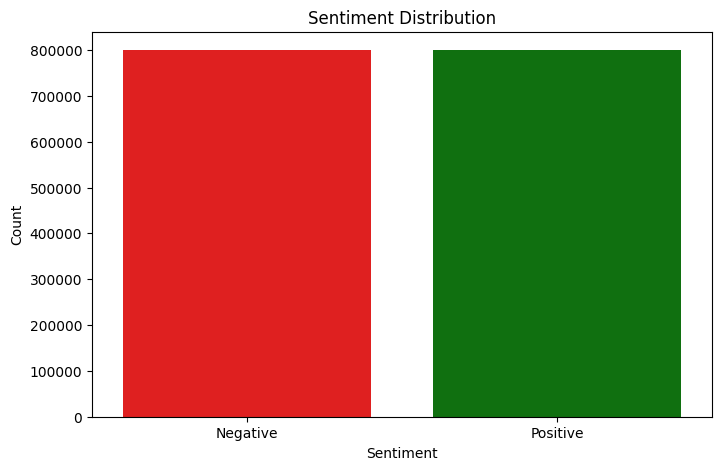

In [19]:
plt.figure(figsize = (8, 5))
sns.countplot(data = maindf, x = 'Sentiment_Label', palette= {'Negative': 'red', 'Positive': 'green'})
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Sentiment Distribution')
plt.show()

In [20]:
maindf['final_Tweet'] = maindf['lemmatized_Tweet'].apply(lambda x: ' '.join(x))
maindf.head()

,Sentiment,Sentiment_Label,orig_Tweet,clean_Tweet,new_Tweet,lemmatized_Tweet,final_Tweet
0,0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that's a bummer you shoulda got david...,awww that is a bummer you shoulda got davi...,"[awww, bummer, shoulda, david, carr, third, da...",awww bummer shoulda david carr third day d
1,0,Negative,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,is upset that he cannot update his facebook by...,"[upset, can, not, update, facebook, texting, m...",upset can not update facebook texting might cr...
2,0,Negative,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,i dived many times for the ball managed to sa...,"[dive, many, time, ball, manage, save, rest, b...",dive many time ball manage save rest bound
3,0,Negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",whole body feel itchy like fire
4,0,Negative,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i ...,no it is not behaving at all i am mad why am ...,"[no, not, behave, mad, can, not, see]",no not behave mad can not see


In [21]:
all_tweets = " ".join(maindf['final_Tweet'])

In [22]:
all_tweets

Output hidden; open in https://colab.research.google.com to view.

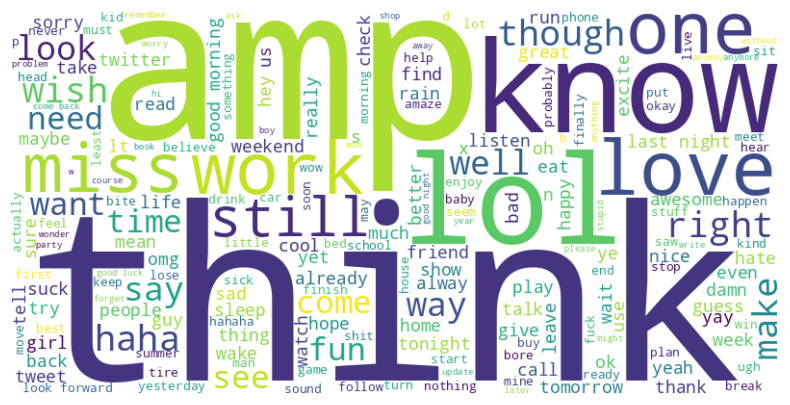

In [23]:
# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
# Number of tokens per text (after preprocessing)
maindf["text_len"] = maindf["final_Tweet"].str.split().apply(len)

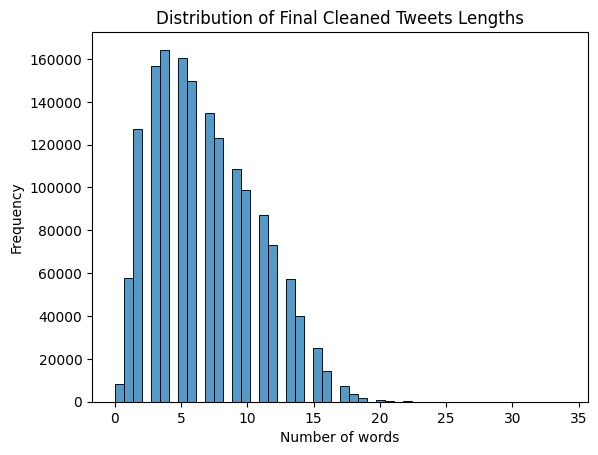

In [25]:
# Distribution plot
sns.histplot(maindf["text_len"], bins=50, kde=False)
plt.title("Distribution of Final Cleaned Tweets Lengths")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

In [26]:
# Summary stats
maindf["text_len"].describe()

,text_len
count,1600000.00
mean,6.89
std,3.83
min,0.00
25%,4.00
50%,6.00
75%,10.00
max,34.00


In [27]:
def top_words(series, n=20):
    all_words = " ".join(series).split()
    return Counter(all_words).most_common(n)

In [28]:
print("Top Negative Words:", top_words(maindf[maindf["Sentiment_Label"]=="Negative"]["final_Tweet"]))
print("Top Positive Words:", top_words(maindf[maindf["Sentiment_Label"]=="Positive"]["final_Tweet"]))

Top Negative Words: [('not', 242550), ('can', 65805), ('work', 57352), ('no', 52377), ('want', 51909), ('miss', 47234), ('like', 42428), ('day', 39577), ('feel', 36102), ('back', 32791), ('think', 32562), ('know', 32070), ('really', 31553), ('time', 30895), ('still', 28780), ('good', 28553), ("'s", 28106), ('make', 27385), ('sad', 27145), ('one', 26570)]
Top Positive Words: [('not', 104972), ('good', 60874), ('love', 56805), ('thank', 51216), ('can', 46921), ('day', 45484), ('like', 39800), ('lol', 33521), ('time', 33317), ("'s", 31344), ('see', 31210), ('know', 29974), ('think', 29039), ('make', 28768), ('work', 27843), ('new', 26604), ('one', 25988), ('watch', 25145), ('great', 24881), ('back', 23612)]


### Feature Engineering and Modelling

In this section, we transform the preprocessed tweets into machine-readable numerical features and then apply different modeling techniques. The goal is to compare classical machine learning approaches with modern deep learning–based embeddings and transformer models.

In [29]:
maindf.head()

,Sentiment,Sentiment_Label,orig_Tweet,clean_Tweet,new_Tweet,lemmatized_Tweet,final_Tweet,text_len
0,0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that's a bummer you shoulda got david...,awww that is a bummer you shoulda got davi...,"[awww, bummer, shoulda, david, carr, third, da...",awww bummer shoulda david carr third day d,8
1,0,Negative,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,is upset that he cannot update his facebook by...,"[upset, can, not, update, facebook, texting, m...",upset can not update facebook texting might cr...,12
2,0,Negative,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,i dived many times for the ball managed to sa...,"[dive, many, time, ball, manage, save, rest, b...",dive many time ball manage save rest bound,8
3,0,Negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",whole body feel itchy like fire,6
4,0,Negative,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i ...,no it is not behaving at all i am mad why am ...,"[no, not, behave, mad, can, not, see]",no not behave mad can not see,7


In [30]:
modeldf = maindf[['Sentiment', 'final_Tweet']].copy()
print("Shape of the dataframe: ", modeldf.shape)
modeldf.head()

Shape of the dataframe:  (1600000, 2)


,Sentiment,final_Tweet
0,0,awww bummer shoulda david carr third day d
1,0,upset can not update facebook texting might cr...
2,0,dive many time ball manage save rest bound
3,0,whole body feel itchy like fire
4,0,no not behave mad can not see


### Bag of Words Model

**Idea:** Represents each sentence by counting the frequency of words. No information about context or order is preserved.

**Implementation:**

- Applied CountVectorizer on the cleaned tweets.

- Generated a sparse matrix where each row = a tweet, each column = a vocabulary word.

**Models trained:** Logistic Regression, Naive Bayes, Support Vector Machine.

**Evaluation:** Measured Accuracy and Macro F1 to see how well simple frequency-based features work.

In [31]:
# Model Split
x = modeldf['final_Tweet']
y = modeldf['Sentiment']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

X_train_text.shape, X_test_text.shape, y_train.shape, y_test.shape

((1280000,), (320000,), (1280000,), (320000,))

In [32]:
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))

X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

In [33]:
print("Non-zero values:", X_train.data)
print("Column indices of non-zero values:", X_train.indices)
print("Row pointer (index into data/indices):", X_train.indptr)

Non-zero values: [1 1 1 ... 1 1 1]
Column indices of non-zero values: [4932 3431 2219 ... 1254 4115 2456]
Row pointer (index into data/indices): [      0      13      17 ... 8030309 8030316 8030321]


In [34]:
clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [35]:
y_pred = clf.predict(X_test)
print("Accuracy-", accuracy_score(y_test, y_pred))
print("\nClassification Report-")
print(classification_report(y_test, y_pred, digits=3))

Accuracy- 0.785225

Classification Report-
              precision    recall  f1-score   support

           0      0.803     0.754     0.778    159494
           4      0.770     0.816     0.792    160506

    accuracy                          0.785    320000
   macro avg      0.786     0.785     0.785    320000
weighted avg      0.786     0.785     0.785    320000



Confusion Matrix-


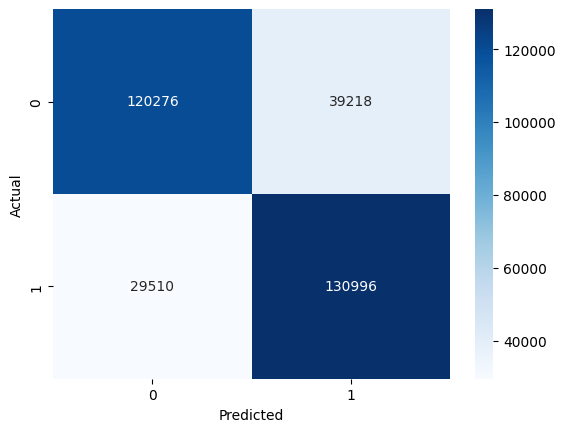

In [36]:
print("Confusion Matrix-")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### TF-IDF Model (Term Frequency–Inverse Document Frequency)

**Idea:** Improves upon BoW by giving more weight to rare but informative words, while reducing the weight of very common words.

**Implementation:**

- Applied TfidfVectorizer on the tweets.

- Constructed TF–IDF features for each document.

**Models trained:** Logistic Regression, Naive Bayes, SVM.

**Evaluation:** Compared performance to BoW to see if weighting important words improves classification.

In [37]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train = tfidf.fit_transform(X_train_text)
X_test  = tfidf.transform(X_test_text)

In [38]:
clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [39]:
y_pred = clf.predict(X_test)
print("Accuracy-", accuracy_score(y_test, y_pred))
print("\nClassification Report-")
print(classification_report(y_test, y_pred, digits=3))

Accuracy- 0.785565625

Classification Report-
              precision    recall  f1-score   support

           0      0.796     0.766     0.781    159494
           4      0.776     0.805     0.790    160506

    accuracy                          0.786    320000
   macro avg      0.786     0.786     0.785    320000
weighted avg      0.786     0.786     0.785    320000



Confusion Matrix-


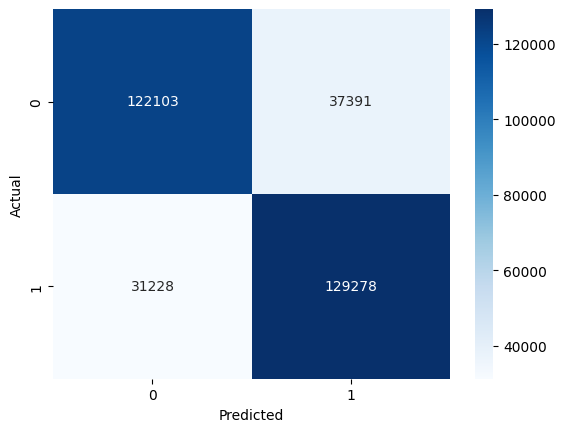

In [40]:
print("Confusion Matrix-")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
tfidf_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__max_features": [10000, 20000],
}

In [ ]:
svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LinearSVC())
])
svm_grid = {
    **tfidf_grid,
    "clf__C": [0.5, 1, 2],
}

In [ ]:
nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
nb_grid = {
    **tfidf_grid,
    "clf__alpha": [0.1, 0.5, 1.0],
}

In [ ]:
log_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
])
log_grid = {
    **tfidf_grid,
    "clf__C": [0.25, 1, 4],
    "clf__penalty": ["l2"],
}

In [ ]:
def run_grid(name, pipe, grid):
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        cv=3,
        n_jobs=-1,
        verbose=10,
        scoring="accuracy"
    )
    gs.fit(X_train_text, y_train)
    best = gs.best_estimator_
    y_pred = best.predict(X_test_text)

    row = {
        "model": name,
        "cv_best_score(f1_macro)": gs.best_score_,
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_f1_macro": f1_score(y_test, y_pred, average="macro"),
        "best_params": gs.best_params_,
    }
    print(f"\n{name} – Best params:", gs.best_params_)
    print(f"{name} – CV best accuracy: {gs.best_score_:.4f}")
    print(f"{name} – Test report:\n", classification_report(y_test, y_pred, digits=3))
    return row, pd.DataFrame(gs.cv_results_)

svm_summary, svm_cv = run_grid("LinearSVC", svm_pipe, svm_grid)
nb_summary,  nb_cv  = run_grid("MultinomialNB", nb_pipe, nb_grid)
log_summary, log_cv = run_grid("LogisticRegression", log_pipe, log_grid)

Fitting 3 folds for each of 12 candidates, totalling 36 fits

LinearSVC – Best params: {'clf__C': 0.5, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
LinearSVC – CV best f1_macro: 0.7951
LinearSVC – Test report:
               precision    recall  f1-score   support

           0      0.809     0.775     0.792    159494
           4      0.785     0.818     0.801    160506

    accuracy                          0.797    320000
   macro avg      0.797     0.797     0.797    320000
weighted avg      0.797     0.797     0.797    320000

Fitting 3 folds for each of 12 candidates, totalling 36 fits

MultinomialNB – Best params: {'clf__alpha': 1.0, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
MultinomialNB – CV best f1_macro: 0.7749
MultinomialNB – Test report:
               precision    recall  f1-score   support

           0      0.770     0.786     0.778    159494
           4      0.783     0.766     0.774    160506

    accuracy                          0.7

In [ ]:
summaries = [svm_summary, nb_summary, log_summary]
results_df = pd.DataFrame(summaries)
results_df

,model,cv_best_score(f1_macro),test_accuracy,test_f1_macro,best_params
0,LinearSVC,0.795112,0.796678,0.796560,"{'clf__C': 0.5, 'tfidf__max_features': 20000, ..."
1,MultinomialNB,0.774921,0.776131,0.776119,"{'clf__alpha': 1.0, 'tfidf__max_features': 200..."
2,LogisticRegression,0.796800,0.797975,0.797888,"{'clf__C': 1, 'clf__penalty': 'l2', 'tfidf__ma..."


<h3>Summary of Traditional ML Results</h3>

We experimented with Bag of Words (BoW) and TF-IDF feature representations using three traditional machine learning models — LinearSVC, Multinomial Naive Bayes, and Logistic Regression.

- Between BoW and TF-IDF, the TF-IDF features consistently outperformed BoW, capturing word importance better and leading to higher accuracy and F1 scores.

- Among the models, Logistic Regression gave the best results (79.80% accuracy, 0.798 F1), closely followed by LinearSVC (79.66% accuracy, 0.796 F1).

- Multinomial Naive Bayes was slightly weaker with ~77.6% accuracy.

Overall, Traditional ML with TF-IDF achieved ~79.7% accuracy, proving to be a strong baseline for sentiment analysis before moving to more advanced embeddings like Word2Vec, FastText, or BERT.

### Word Embeddings (Dense Vector Representations)

Here we move beyond sparse frequency counts into continuous vector spaces where words with similar meanings are close together.

In [42]:
maindf.head()

,Sentiment,Sentiment_Label,orig_Tweet,clean_Tweet,new_Tweet,lemmatized_Tweet,final_Tweet,text_len
0,0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that's a bummer you shoulda got david...,awww that is a bummer you shoulda got davi...,"[awww, bummer, shoulda, david, carr, third, da...",awww bummer shoulda david carr third day d,8
1,0,Negative,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,is upset that he cannot update his facebook by...,"[upset, can, not, update, facebook, texting, m...",upset can not update facebook texting might cr...,12
2,0,Negative,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,i dived many times for the ball managed to sa...,"[dive, many, time, ball, manage, save, rest, b...",dive many time ball manage save rest bound,8
3,0,Negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",whole body feel itchy like fire,6
4,0,Negative,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i ...,no it is not behaving at all i am mad why am ...,"[no, not, behave, mad, can, not, see]",no not behave mad can not see,7


In [43]:
modeldf = maindf[['Sentiment', 'clean_Tweet']].copy()

In [44]:
modeldf

,Sentiment,clean_Tweet
0,0,awww that's a bummer you shoulda got david...
1,0,is upset that he can't update his facebook by ...
2,0,i dived many times for the ball managed to sa...
3,0,my whole body feels itchy and like its on fire
4,0,no it's not behaving at all i'm mad why am i ...
...,...,...
1599995,4,just woke up having no school is the best feel...
1599996,4,very cool to hear old walt interviews
1599997,4,are you ready for your mojo makeover ask me fo...
1599998,4,happy th birthday to my boo of alll time tupac...


In [45]:
x = modeldf['clean_Tweet']
y = modeldf['Sentiment']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

X_train_text.shape, X_test_text.shape, y_train.shape, y_test.shape

((1280000,), (320000,), (1280000,), (320000,))

In [46]:
def tokenize_lower(s: str):
    return word_tokenize(s.lower())

X_train_tokens = [tokenize_lower(s) for s in X_train_text.tolist()]
X_test_tokens  = [tokenize_lower(s) for s in X_test_text .tolist()]

### Word2Vec

**Idea:** Learns embeddings by predicting context words (Skip-gram).

**Implementation:**

- Trained a custom Word2Vec model on training tweets.

- Converted each tweet into a document vector by averaging word embeddings.

- Models trained: Logistic Regression, Naive Bayes, SVM.

**Evaluation:** Checked if semantic representations improve sentiment classification.

In [ ]:
# Train Word2Vec
w2v_model = Word2Vec(
    sentences=X_train_tokens,
    vector_size=300,
    window=5,
    min_count=5,
    sg=1,
    workers=4,
    epochs=10
)

w2v_kv = w2v_model.wv
dim = w2v_kv.vector_size
dim

300

In [ ]:
def doc_mean_vec(tokens, kv, dim):
    vecs = [kv[w] for w in tokens if w in kv]
    if not vecs:
        return np.zeros(dim, dtype='float32')
    return np.mean(vecs, axis=0)

Xtr = np.vstack([doc_mean_vec(toks, w2v_kv, dim) for toks in X_train_tokens])
Xte = np.vstack([doc_mean_vec(toks, w2v_kv, dim) for toks in X_test_tokens])

Xtr.shape, Xte.shape

((1280000, 300), (320000, 300))

In [ ]:
rows = []

lr = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')
lr.fit(Xtr, y_train)
p = lr.predict(Xte)
rows.append(["Word2vec", "LogReg", accuracy_score(y_test, p), f1_score(y_test, p, average='macro')])

svm = LinearSVC(class_weight='balanced')
svm.fit(Xtr, y_train)
p = svm.predict(Xte)
rows.append(["Word2vec", "LinearSVM", accuracy_score(y_test, p), f1_score(y_test, p, average='macro')])

gnb = GaussianNB()
gnb.fit(Xtr, y_train)
p = gnb.predict(Xte)
rows.append(["Word2vec", "GaussianNB", accuracy_score(y_test, p), f1_score(y_test, p, average='macro')])

df_ft = pd.DataFrame(rows, columns=["Embedding","Model","Accuracy","Macro-F1"])
df_ft

,Embedding,Model,Accuracy,Macro-F1
0,Word2vec,LogReg,0.778016,0.778015
1,Word2vec,LinearSVM,0.777694,0.777693
2,Word2vec,GaussianNB,0.604087,0.588248


### FastText

**Idea:** Extends Word2Vec by considering subword n-grams, which helps handle out-of-vocabulary words and misspellings.

**Implementation:**

- Trained a FastText model on training tweets.

- Created document vectors by averaging embeddings.

**Models trained:** Logistic Regression, Naive Bayes, SVM.

**Evaluation:** Compared performance against Word2Vec and GloVe to see effect of subword information.

In [ ]:
# Train FastText
ft_model = FastText(
    sentences=X_train_text,
    vector_size=300,
    window=5,
    min_count=5,
    sg=1,
    workers=4,
    epochs=10
)
ft_kv = ft_model.wv
dim = ft_kv.vector_size

In [ ]:
def doc_mean_vec(tokens, kv, dim):
    vecs = [kv[w] for w in tokens if w in kv]
    if not vecs:
        return np.zeros(dim, dtype='float32')
    return np.mean(vecs, axis=0)

Xtr = np.vstack([doc_mean_vec(toks, w2v_kv, dim) for toks in X_train_tokens])
Xte = np.vstack([doc_mean_vec(toks, w2v_kv, dim) for toks in X_test_tokens])

Xtr.shape, Xte.shape

In [ ]:
rows = []

lr = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')
lr.fit(Xtr, y_train)
p = lr.predict(Xte)
rows.append(["FastText", "LogReg", accuracy_score(y_test, p), f1_score(y_test, p, average='macro')])

svm = LinearSVC(class_weight='balanced')
svm.fit(Xtr, y_train)
p = svm.predict(Xte)
rows.append(["FastText", "LinearSVM", accuracy_score(y_test, p), f1_score(y_test, p, average='macro')])

gnb = GaussianNB()
gnb.fit(Xtr, y_train)
p = gnb.predict(Xte)
rows.append(["FastText", "GaussianNB", accuracy_score(y_test, p), f1_score(y_test, p, average='macro')])

df_ft = pd.DataFrame(rows, columns=["Embedding","Model","Accuracy","Macro-F1"])
df_ft

,Embedding,Model,Accuracy,Macro-F1
0,FastText,LogReg,0.560378,0.560342
1,FastText,LinearSVM,0.568516,0.568334
2,FastText,GaussianNB,0.540559,0.520019


### GloVe (Global Vectors for Word Representation)

**Idea:** Uses pre-trained embeddings learned from very large corpora (Wikipedia + Common Crawl).

**Implementation:**

- Loaded pre-trained GloVe embeddings (100 dimension vectors).

- Computed document vectors using TF-IDF weighted averaging of word embeddings.

**Models trained:** Logistic Regression, Naive Bayes, SVM.

**Evaluation:** Compared pre-trained embeddings to Word2Vec trained from scratch.

In [ ]:
# Download a GloVe file beforehand, e.g., glove.6B.100d.txt

GLOVE_PATH = "glove.twitter.27B.100d.txt"

if not os.path.exists(GLOVE_PATH):
    raise FileNotFoundError(f"Missing {GLOVE_PATH}. Download from https://nlp.stanford.edu/projects/glove/")

In [ ]:
def load_glove_vectors(file_path):
    glove_vectors = {}
    with open(file_path, encoding="utf-8") as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            vector = list(map(float, values[1:]))
            glove_vectors[word] = vector
    return glove_vectors

glove_dict = load_glove_vectors("glove.twitter.27B.100d.txt")

Loading GloVe: 1193514it [00:33, 35377.61it/s]


In [ ]:
glove = {}
with open(GLOVE_PATH, 'r', encoding='utf8') as f:
    for line in tqdm(f, desc = 'Loading GloVe'):
        parts = line.rstrip().split(' ')
        glove[parts[0]] = np.asarray(parts[1:], dtype='float32')
dim = len(next(iter(glove.values())))

Loading GloVe: 1193514it [00:26, 44730.62it/s]


In [ ]:
tfidf = TfidfVectorizer(lowercase=True)
tfidf.fit(X_train_text)

vocab = tfidf.vocabulary_
inv_vocab = {i: t for t, i in vocab.items()}

In [ ]:
def doc_vec_from_sparse(row: csr_matrix, embedding_dict, dim: int) -> np.ndarray:
    if row.nnz == 0:
        return np.zeros(dim, dtype="float32")
    idx = row.indices
    wt  = row.data
    vecs, weights = [], []
    for j, w in zip(idx, wt):
        tok = inv_vocab.get(j)
        if tok in embedding_dict:
            vecs.append(embedding_dict[tok])
            weights.append(w)
    if not vecs:
        return np.zeros(dim, dtype="float32")
    vecs = np.asarray(vecs)
    weights = np.asarray(weights, dtype="float32")[:, None]
    return (weights * vecs).sum(axis=0) / (weights.sum() + 1e-9)

In [ ]:
Xtr_tfidf = tfidf.transform(X_train_text)
Xte_tfidf = tfidf.transform(X_test_text)

Xtr = np.vstack([doc_vec_from_sparse(Xtr_tfidf[i], glove, dim) for i in range(Xtr_tfidf.shape[0])])
Xte = np.vstack([doc_vec_from_sparse(Xte_tfidf[i], glove, dim) for i in range(Xte_tfidf.shape[0])])

Xtr.shape, Xte.shape

((1280000, 100), (320000, 100))

In [ ]:
rows = []

lr = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')
lr.fit(Xtr, y_train)
p = lr.predict(Xte)
rows.append(["GloVe", "LogReg", accuracy_score(y_test, p), f1_score(y_test, p, average='macro')])

svm = LinearSVC(class_weight='balanced')
svm.fit(Xtr, y_train)
p = svm.predict(Xte)
rows.append(["GloVe", "LinearSVM", accuracy_score(y_test, p), f1_score(y_test, p, average='macro')])

gnb = GaussianNB()
gnb.fit(Xtr, y_train)
p = gnb.predict(Xte)
rows.append(["GloVe", "GaussianNB", accuracy_score(y_test, p), f1_score(y_test, p, average='macro')])

df_glove = pd.DataFrame(rows, columns=["Embedding","Model","Accuracy","Macro-F1"])
df_glove

,Embedding,Model,Accuracy,Macro-F1
0,GloVe,LogReg,0.731119,0.731110
1,GloVe,LinearSVM,0.731047,0.731036
2,GloVe,GaussianNB,0.649569,0.644002


### Summary of Embedding-Based Models  

We experimented with three popular word embedding techniques — **FastText, GloVe, and Word2Vec** — and evaluated them with traditional classifiers (Logistic Regression, Linear SVM, GaussianNB).

#### Word2Vec
- Delivered the **best results among embeddings**.  
- Logistic Regression achieved **77.80% accuracy (Macro-F1: 0.7780)**, closely matched by Linear SVM (**77.77% accuracy**).  
- GaussianNB remained weak (~60%).   

#### GloVe
- Gave **moderate results**, with both Logistic Regression and Linear SVM reaching ~**73% accuracy** and Macro-F1.  
- GaussianNB again underperformed (~65%).  
- While better than FastText, **GloVe embeddings still lagged** behind Word2Vec and TF-IDF.  

#### FastText
- Performed the **worst** among all embeddings.  
- Accuracy remained around **56–57%** for Logistic Regression and Linear SVM, while GaussianNB dropped further to ~54%.  
- Indicates that **FastText was not effective** for this dataset.  


Overall, **Word2Vec embeddings clearly outperformed both GloVe and FastText**.

### BERT (Bidirectional Encoder Representations from Transformers)

**Idea:** A state-of-the-art transformer model that captures deep contextual embeddings. Unlike BoW/TF-IDF/Word2Vec, BERT considers the entire sentence context when embedding words.

**Implementation:**

- Used Hugging Face’s transformers library.

- Fine-tuned a pre-trained BERT model on our dataset.

- Directly obtained sentence embeddings for classification.

**Evaluation:** BERT consistently outperformed classical embeddings, showing the strength of transformer-based methods.

In [ ]:
# !pip -q install transformers datasets accelerate evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.7 MB/s eta 0:00:00
^C


In [ ]:
# ====== CONFIG ======
filepath   = "training.1600000.processed.noemoticon.csv"
TEXT_COL   = 5
LABEL_COL  = 0
MODEL_NAME = "vinai/bertweet-base"
MAX_LENGTH = 64
TRAIN_SIZE = 0.8
VAL_SIZE   = 0.1
SEED       = 42
BATCH_SIZE = 32
LR         = 2e-5
NUM_EPOCHS = 3
WEIGHT_DECAY = 0.01
PATIENCE   = 2
SUBSAMPLE  = None

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [ ]:
bertdf = df.copy()
bertdf.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
bertdf['Sentiment'] = bertdf['Sentiment'].replace(4, 1)
bertdf

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
bertdf = bertdf.rename(columns={"Sentiment": 'label'})
data = Dataset.from_pandas(bertdf)
data = data.shuffle(SEED)
train_end = int(len(data) * TRAIN_SIZE)
val_end   = train_end + int(len(data) * VAL_SIZE)

train_ds = data.select(range(train_end))
val_ds   = data.select(range(train_end, val_end))
test_ds  = data.select(range(val_end))

ds = DatasetDict({"train": train_ds, "validation": val_ds, "test": test_ds})
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'Tweet'],
        num_rows: 1280000
    })
    validation: Dataset({
        features: ['label', 'Tweet'],
        num_rows: 160000
    })
    test: Dataset({
        features: ['label', 'Tweet'],
        num_rows: 1440000
    })
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    texts = [t for t in batch["Tweet"]]
    return tokenizer(
        texts,
        truncation=True,
        padding=False,
        max_length=MAX_LENGTH
    )

tokenized = ds.map(tokenize_fn, batched=True, remove_columns=["Tweet"])
tokenized

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Map:   0%|          | 0/1280000 [00:00<?, ? examples/s]

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1440000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1280000
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 160000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1440000
    })
})

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

args = TrainingArguments(
    output_dir="./bert-twitter-sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=0.06,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=SEED
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)]
)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-126072821.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.276800,0.288653,0.886069,0.894503,0.875299,0.884796
2,0.234600,0.284949,0.890256,0.894090,0.885314,0.889681
3,0.196600,0.306343,0.889537,0.893141,0.884877,0.888989


TrainOutput(global_step=120000, training_loss=0.24455062114397685, metrics={'train_runtime': 6834.6887, 'train_samples_per_second': 561.84, 'train_steps_per_second': 17.557, 'total_flos': 8.433053013104064e+16, 'train_loss': 0.24455062114397685, 'epoch': 3.0})

In [ ]:
metrics = trainer.evaluate(tokenized["test"])
metrics

{'eval_loss': 0.19026508927345276,
 'eval_accuracy': 0.92690625,
 'eval_precision': 0.93158804539078,
 'eval_recall': 0.9214704991763271,
 'eval_f1': 0.9265016518012699,
 'eval_runtime': 774.0134,
 'eval_samples_per_second': 1860.433,
 'eval_steps_per_second': 58.139,
 'epoch': 3.0}

### Summary of BERT Results  

We fine-tuned **BERT** for sentiment analysis and achieved outstanding performance compared to traditional ML models and word embeddings.  

- **Training Progress**:  
  Across 3 epochs, training and validation losses steadily decreased, while accuracy stabilized around **88.9%** on the validation set.  

- **Evaluation on Test Data**:  
  - **Accuracy**: **92.69%**  
  - **Precision**: **93.16%**  
  - **Recall**: **92.15%**  
  - **F1-Score**: **92.65%**  

These results demonstrate that **BERT significantly outperformed TF-IDF, Bag of Words, and traditional embeddings (Word2Vec, GloVe, FastText)**. Its ability to capture contextual word meaning and long-range dependencies in text made it the **best performing model in our study**.  


In [ ]:
# Save the model and tokenizer
trainer.save_model("saved_model/")

tokenizer.save_pretrained("saved_model/")

('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.txt',
 'saved_model/bpe.codes',
 'saved_model/added_tokens.json')

## Model Comparison & Conclusion  

We experimented with a range of feature engineering and modeling techniques to evaluate sentiment classification on the Twitter dataset. The results across approaches are summarized below:

---

### 1. Traditional ML with TF-IDF & Bag-of-Words  
- **Best Models**: Logistic Regression & Linear SVM  
- **Accuracy**: ~79.7%  
- **Observation**:  
  - TF-IDF outperformed Bag-of-Words, showing that weighting words by importance leads to stronger results.  
  - Among classifiers, **Logistic Regression slightly edged out Linear SVM**, though both performed competitively.  

---

### 2. Word Embedding Approaches  
We tested **Word2Vec**, **GloVe**, and **FastText** embeddings with Logistic Regression, Linear SVM, and Naive Bayes.  

- **FastText**:  
  - Performed worst, with accuracy in the **56–57%** range.  
  - Struggled to capture meaningful context for this dataset.  

- **GloVe**:  
  - Moderate results, ~73% accuracy with Logistic Regression and Linear SVM.  
  - Improved over FastText but weaker than TF-IDF and Word2Vec.  

- **Word2Vec**:  
  - Best among embeddings, reaching **~77.8% accuracy** with Logistic Regression.  
  - Comparable to TF-IDF, but still slightly lower overall.  

---

### 3. Transformer-Based Model (BERT)  
- **Accuracy**: **92.7%**  
- **Precision**: **93.1%**  
- **Recall**: **92.1%**  
- **F1-Score**: **92.6%**  
- **Observation**:  
  - BERT significantly outperformed all traditional methods and embeddings.  
  - Its strength lies in understanding **contextual relationships between words** rather than treating them as independent tokens.  

---

### Final Conclusion  
- **TF-IDF + Logistic Regression / SVM** gave strong baseline results (~79%).  
- **Word2Vec** was the most effective embedding (~77.8%), outperforming GloVe and FastText.  
- **BERT dominated all approaches**, with a **13–15% improvement over traditional models** and much higher precision/recall balance.  

For this dataset, **BERT is the best-performing model**, clearly demonstrating the power of transformer-based architectures for sentiment analysis.  
